# Perplexity ratio score: Kullback–Leibler divergence

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from IPython.display import Image

import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import configuration as config

/mnt/arkk/llm_detector/classifier


Plan here is to take our sampling distributions of perplexity ratio scores for human and synthetic text and use them to generate a function that takes a perplexity ratio score and converts it into a Kullback-Leibler score. See the figure below from the [Wikipedia article on KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [2]:
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

Plan is as follows:
2. Plot and fit the distributions of perplexity ratio scores from human and synthetic text from the training data.
3. Calculate the Kullback-Leibler divergence between the fitted distributions.
4. Use a kernel density estimate of the Kullback-Leibler divergence to get it's probability density function.
5. Use the Kullback-Leibler divergence PDF to calculate a 'Kullback-Leibler score' from the perplexity ratio score for each text fragment in the training and testing datasets.

## TODO
1. ~~Since KL divergence is not symmetrical, maybe we should include two features one for KL divergence between the human and synthetic score distributions in each direction...~~
2. ~~Maybe try some of the other fits, e.g. gaussian rather than exponential gaussian.~~ Took a good second look at the old version of the experimentation notebook and the fit residuals are without a doubt best with exponential gaussian.
3. ~~What if we use a kernel density estimate instead of a gaussian fit on the perplexity ratio density data? This might give us a better 'fit'.~~ Seems like classifier performance downstream in just slightly better with KDE than gaussian fit. Also feature selection methods seem to prefer the KDE based score as well. But, it's not a large difference.

## Load and prepare data

In [3]:
# The dataset we want to bin - omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
hdf5_file = f'{config.DATA_PATH}/{dataset_name}.h5'

# Open a connection to the hdf5 dataset via PyTables with Pandas so we can
# load the data from each bin as a dataframe
data_lake = pd.HDFStore(hdf5_file)

# Load bin data
data_df = data_lake[f'master']

# Take small sample for rapid development and testing
data_df = data_df.sample(n = 5000)

# Close hdf5 connection
data_lake.close()

data_df.head()

,Fragment ID,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,Perplexity ratio score,Reader time (seconds),Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB)
30712,30712,8082,167,193,cnn,human,human,"and received a posy. In the 1980s, Wing Comman...",2.916,3.060547,0.952776,3.137474,3.434646,6.225164,6.180670
18856,18856,6916,17,21,cnn,synthetic,llama2-13b,condition.\nWA police confirmed Mr Cousins was...,4.066,3.972656,1.023599,1.037065,1.100543,4.712623,4.707431
479,479,6649,297,476,cc_news,human,human,"Minton, won the Booth Cup for most points in t...",3.488,3.488281,1.000000,5.736159,6.578206,7.730958,7.709705
54396,54396,6403,209,314,cc_news,synthetic,llama2-13b,and Mirai Nagasu of the United States did not ...,2.080,2.507812,0.829439,3.831655,4.267622,7.854102,7.768151
4666,4666,5171,71,83,cc_news,synthetic,llama2-13b,bar to stop using Oilers branded posters becau...,3.342,3.466797,0.963944,1.900358,2.090381,5.349480,5.323896


First we need the distributions of perplexity ratio score values for human and synthetic text.

In [4]:
# Calculate bins for perplexity ratio score from the training data
scores = data_df['Perplexity ratio score']
counts, bins = np.histogram(np.array(scores), bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and combined synthetic data
human_scores = data_df['Perplexity ratio score'][data_df['Source'] == 'human']
synthetic_scores = data_df['Perplexity ratio score'][data_df['Source'] == 'synthetic']

human_density, human_bins = np.histogram(human_scores, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(synthetic_scores, bins = bins, density = True)

Now, fit the individual distributions with an exponential gaussian:

In [5]:
# Fit an exponential gaussian to the human and synthetic scores and get fitted values for
# the bin centers calculated from the combined data

print('\nHuman fit:')
human_exp_gaussian = helper_funcs.exp_gaussian_fit(
    human_scores,
    bounds = [[0.0, 1.0], [0.0, 2.0], [0.001, 1.0]]
)

human_exp_gaussian_values = human_exp_gaussian.pdf(bin_centers)
print(f'  Fitted values: {human_exp_gaussian_values[:3]}...')

print('\nSynthetic fit:')
synthetic_exp_gaussian = helper_funcs.exp_gaussian_fit(
    synthetic_scores,
    bounds = [[0.0, 1.0], [0.0, 2.0], [0.001, 1.0]]
)

synthetic_exp_gaussian_values = synthetic_exp_gaussian.pdf(bin_centers)
print(f'  Fitted values: {synthetic_exp_gaussian_values[:3]}...')


Human fit:
  Shape: 0.6908816135926079
  Mean: 0.9483782368286736
  Variance: 0.058744020443575996
  Fitted values: [7.19713844e-16 2.88803518e-15 1.12769537e-14]...

Synthetic fit:
  Shape: 0.6907342118429148
  Mean: 0.8350180543038782
  Variance: 0.06005007225950659
  Fitted values: [3.33032362e-09 9.30601102e-09 2.53374563e-08]...


/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1782: RuntimeWarning: overflow encountered in scalar divide
  invK = 1.0 / K


And for comparison, also use a guassian kernel density estimate to get the fit:

In [6]:
# Run the KDE and then get fitted values for the bin centers
human_kde = gaussian_kde(human_scores)
human_kde_values = human_kde.pdf(bin_centers)
print(f'Human KDE values: {human_kde_values[:3]}...')

synthetic_kde = gaussian_kde(synthetic_scores)
synthetic_kde_values = synthetic_kde.pdf(bin_centers)
print(f'Synthetic KDE values: {synthetic_kde_values[:3]}...')

Human KDE values: [7.52193739e-43 3.83688070e-39 1.29447895e-35]...
Synthetic KDE values: [0.00973605 0.00654509 0.00295863]...


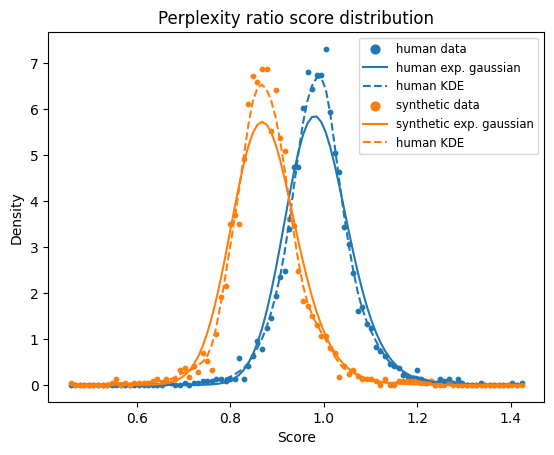

In [7]:
plot_funcs.plot_score_distribution_fits(
        'Perplexity ratio score distribution',
        bin_centers,
        human_density,
        human_exp_gaussian_values,
        human_kde_values,
        synthetic_density,
        synthetic_exp_gaussian_values,
        synthetic_kde_values
).show()

Ok, looks good to me - let's take a closer look at the fits.

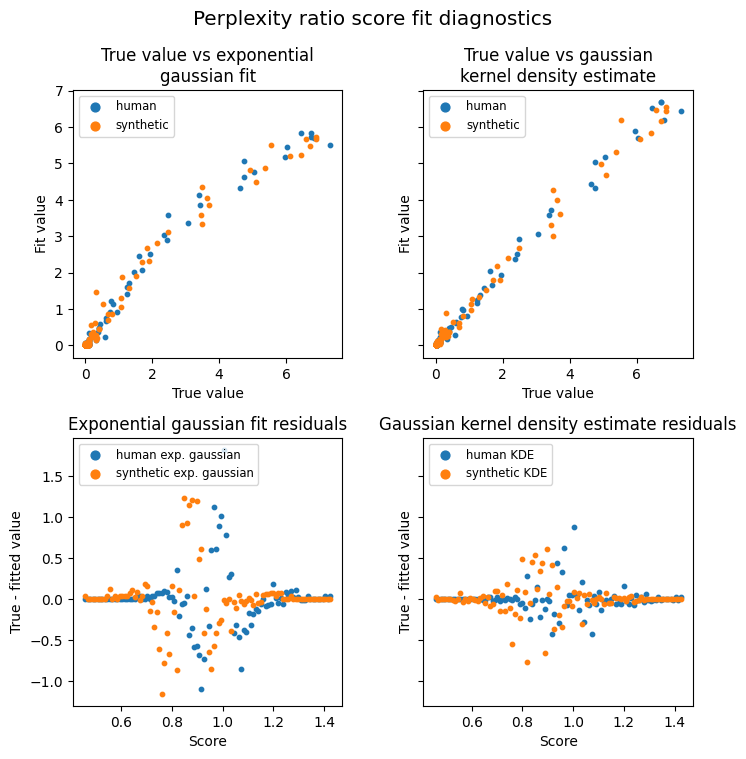

In [8]:
plot_funcs.plot_fit_diagnostics(
        'Perplexity ratio score fit diagnostics',
        bin_centers,
        human_density,
        synthetic_density,
        human_exp_gaussian_values,
        synthetic_exp_gaussian_values,
        human_kde_values,
        synthetic_kde_values
).show()

OK, looks good enough to me - now let's take a look at the Kullback-Leibler divergence of the two fits.

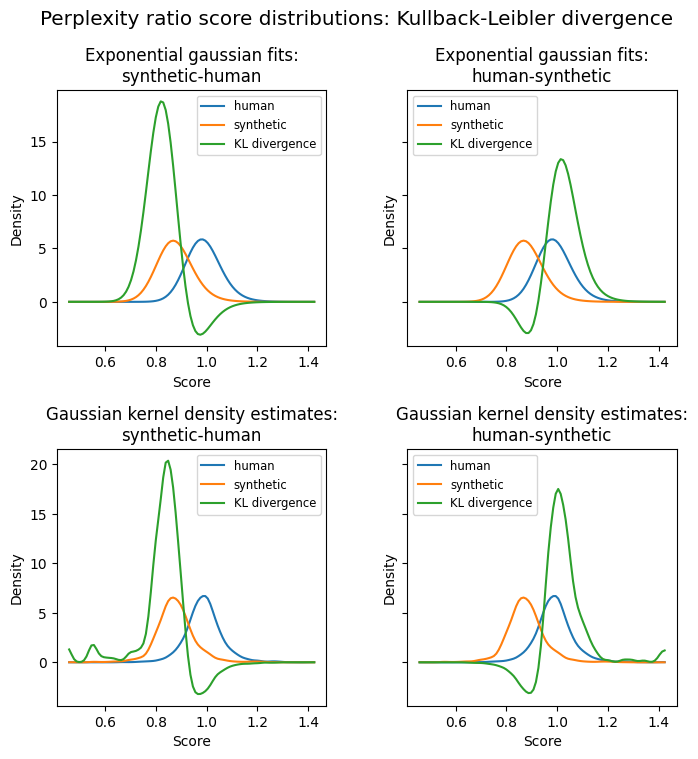

In [9]:
plot_funcs.plot_kl_divergences(
        'Perplexity ratio score distributions: Kullback-Leibler divergence',
        bin_centers,
        human_exp_gaussian_values,
        synthetic_exp_gaussian_values,
        human_kde_values,
        synthetic_kde_values

).show()

Now we need to use fitted perplexity ratio score distributions to calculate and add the KL score for each text fragment in the dataset. E.g. on the plot above a fragment with a perplexity ratio score of ~0.8 would get a synthetic-human KL divergence score of about 25, etc. To do that we need kernel density estimates for the KL divergence distributions.

Will calculate 1176 fitted values
Min synthetic-human KLD count value 0
Max synthetic-human KLD count value: 2186
Min human-synthetic KLD count value 0
Max human-synthetic KLD count value: 1631


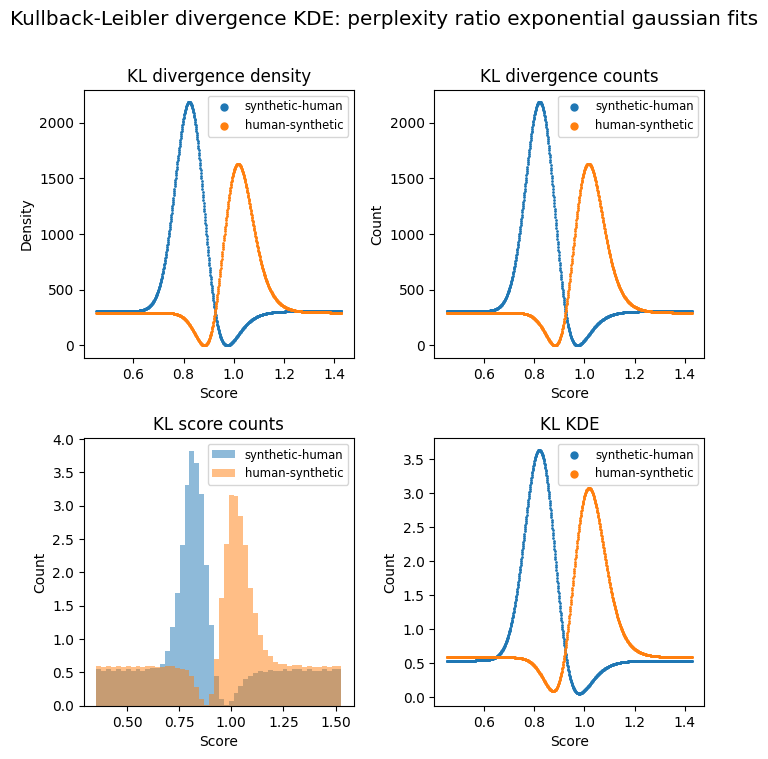

In [10]:
exp_gaussian_synthetic_human_kld_kde, exp_gaussian_human_synthetic_kld_kde, plt = helper_funcs.get_kl_kde(
    'Kullback-Leibler divergence KDE: perplexity ratio exponential gaussian fits', 
    scores, 
    human_exp_gaussian, 
    synthetic_exp_gaussian,
    0.1,
    0.001
)

plt.show()

In [11]:
kde_synthetic_human_kld_kde, kde_human_synthetic_kld_kde, plt = helper_funcs.get_kl_kde(
    'Kullback-Leibler divergence KDE: perplexity ratio kernel density estimate', 
    scores, 
    human_kde, 
    synthetic_kde,
    0.1,
    0.001
)

plt.show()

Will calculate 1176 fitted values
Min synthetic-human KLD count value 0
Max synthetic-human KLD count value: 2364
Min human-synthetic KLD count value 0
Max human-synthetic KLD count value: 2062


OK, cool. Looks good. Now we can run the perplexity ratio score column from the complete dataset through the Kullback-Leibler divergence distribution's kernel density estimate probability density function to get 'Kullback-Leibler scores' and add them to the dataframe.

In [12]:
# Get the KLD scores
synthetic_human_kld_scores = exp_gaussian_synthetic_human_kld_kde.pdf(data_df['Perplexity ratio score'])
human_synthetic_kld_scores = exp_gaussian_human_synthetic_kld_kde.pdf(data_df['Perplexity ratio score'])

# Add the scores to the dataframe
data_df['Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score'] = synthetic_human_kld_scores
data_df['Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score'] = human_synthetic_kld_scores

# Get the KLD scores
synthetic_human_kld_scores = kde_synthetic_human_kld_kde.pdf(data_df['Perplexity ratio score'])
human_synthetic_kld_scores = kde_human_synthetic_kld_kde.pdf(data_df['Perplexity ratio score'])

# Add the scores to the dataframe
data_df['Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score'] = synthetic_human_kld_scores
data_df['Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score'] = human_synthetic_kld_scores

Re-plot just to be sure we got the result we expected

In [ ]:
plt.title('Kullback-Leibler score, exponential gaussian fits')
plt.scatter(data_df['Perplexity ratio score'], data_df['Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score'], s = 1, label = 'synthetic-human')
plt.scatter(data_df['Perplexity ratio score'], data_df['Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score'], s = 1, label = 'human-synthetic')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.legend(loc = 'upper right', fontsize = 'small', markerscale = 5)
plt.show()

In [ ]:
plt.title('Kullback-Leibler score, kernel density estimates')
plt.scatter(data_df['Perplexity ratio score'], data_df['Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score'], s = 1, label = 'synthetic-human')
plt.scatter(data_df['Perplexity ratio score'], data_df['Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score'], s = 1, label = 'human-synthetic')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.legend(loc = 'upper right', fontsize = 'small', markerscale = 5)
plt.show()

Nailed it!